<a href="https://colab.research.google.com/github/Ravi1603/Taxi_fare_prediction/blob/main/Taxi_Fare_Prediction_using_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement:** This case study is to predict the taxi fare for a ride in New York City from a given pickup point to agreed dropoff location. Decision tree and Random Forest regressor is used for the fare prediction

**A decision tree** is a type of supervised learning algorithm that is commonly used in machine learning to model and predict outcomes based on input data. It is a tree-like structure where each internal node tests on attribute, each branch corresponds to attribute value and each leaf node represents the final decision or prediction. The decision tree algorithm falls under the category of supervised learning. They can be used to solve both regression and classification problems.

**Random forests or random decision forests** is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time

In [ ]:
#To ignore warinings
from warnings import filterwarnings
filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
from math import radians,cos,sin,sqrt,asin

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:
plt.rcParams['figure.figsize']=[15,8]

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.6f}'.format

In [ ]:
df_taxi = pd.read_csv('/content/TaxiFare.csv')
df_taxi.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.500000,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.900000,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.700000,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.700000,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.300000,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
df_taxi=df_taxi.drop('unique_id',axis=1)

In [ ]:
df_taxi.shape  # It means there are 7 variables and 50,000 observations

(50000, 7)

In [ ]:
df_taxi.dtypes

amount                  float64
date_time_of_pickup      object
longitude_of_pickup     float64
latitude_of_pickup      float64
longitude_of_dropoff    float64
latitude_of_dropoff     float64
no_of_passenger           int64
dtype: object

datatype of date_time_of_pickup is object which is supposed to be timestamp


In [ ]:
df_taxi.date_time_of_pickup = pd.to_datetime(df_taxi.date_time_of_pickup,errors='coerce')

In [ ]:
df_taxi.dtypes

amount                              float64
date_time_of_pickup     datetime64[ns, UTC]
longitude_of_pickup                 float64
latitude_of_pickup                  float64
longitude_of_dropoff                float64
latitude_of_dropoff                 float64
no_of_passenger                       int64
dtype: object

Feature Engineering

In [ ]:
df_taxi = df_taxi.assign(hour = df_taxi.date_time_of_pickup.dt.hour,
                         day = df_taxi.date_time_of_pickup.dt.day,
                         month = df_taxi.date_time_of_pickup.dt.month,
                         year = df_taxi.date_time_of_pickup.dt.year,
                         dayofweek = df_taxi.date_time_of_pickup.dt.dayofweek)
df_taxi.head()

,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek
0,4.500000,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0
1,16.900000,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1
2,5.700000,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3
3,7.700000,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5
4,5.300000,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1


In [ ]:
# func to calc distance from longitudes and latitudes
def distance_transform(longitude1, latitude1, longitude2, latitude2):
  travel_dist = []
  for pos in range(len(longitude1)):
    long1,lati1,long2,lati2 = map(radians, [longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
    dist_long = long2 - long1
    dist_lati = lati2 - lati1
    a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
    c = 2*asin(sqrt(a))*6371
    travel_dist.append(c)
  return travel_dist


In [ ]:
distance_transform

<function __main__.distance_transform(longitude1, latitude1, longitude2, latitude2)>

In [ ]:
#add a new variable distance
df_taxi['travel_dist_km'] = distance_transform(df_taxi['longitude_of_pickup'].to_numpy(),
                                               df_taxi['latitude_of_pickup'].to_numpy(),
                                               df_taxi['longitude_of_dropoff'].to_numpy(),
                                               df_taxi['latitude_of_dropoff'].to_numpy())

In [ ]:
df_taxi.head(5)

,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,4.500000,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,16.900000,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,5.700000,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,7.700000,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,5.300000,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


In [ ]:
df_taxi = df_taxi.drop('date_time_of_pickup', axis = 1)

In [ ]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   amount                50000 non-null  float64
 1   longitude_of_pickup   50000 non-null  float64
 2   latitude_of_pickup    50000 non-null  float64
 3   longitude_of_dropoff  50000 non-null  float64
 4   latitude_of_dropoff   50000 non-null  float64
 5   no_of_passenger       50000 non-null  int64  
 6   hour                  50000 non-null  int32  
 7   day                   50000 non-null  int32  
 8   month                 50000 non-null  int32  
 9   year                  50000 non-null  int32  
 10  dayofweek             50000 non-null  int32  
 11  travel_dist_km        50000 non-null  float64
dtypes: float64(6), int32(5), int64(1)
memory usage: 3.6 MB


In [ ]:
df_taxi.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
amount,50000.000000,11.364171,9.685557,-5.000000,6.000000,8.500000,12.500000,200.000000
longitude_of_pickup,50000.000000,-72.509756,10.393860,-75.423848,-73.992062,-73.981840,-73.967148,40.783472
latitude_of_pickup,50000.000000,39.933759,6.224857,-74.006893,40.734880,40.752678,40.767360,401.083332
longitude_of_dropoff,50000.000000,-72.504616,10.407570,-84.654241,-73.991152,-73.980082,-73.963584,40.851027
latitude_of_dropoff,50000.000000,39.926251,6.014737,-74.006377,40.734372,40.753372,40.768167,43.415190
no_of_passenger,50000.000000,1.667840,1.289195,0.000000,1.000000,1.000000,2.000000,6.000000
hour,50000.000000,13.489080,6.506935,0.000000,9.000000,14.000000,19.000000,23.000000
day,50000.000000,15.672040,8.660789,1.000000,8.000000,16.000000,23.000000,31.000000
month,50000.000000,6.273300,3.461157,1.000000,3.000000,6.000000,9.000000,12.000000
year,50000.000000,2011.739260,1.862639,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000


In [ ]:
df_taxi = df_taxi.loc[(df_taxi.amount >= 2.5)]
print("Remaining observations in the dataset:", df_taxi.shape)

Remaining observations in the dataset: (49990, 12)


In [ ]:
df_taxi = df_taxi.loc[(df_taxi.travel_dist_km >= 1) | (df_taxi.travel_dist_km <= 130)]
print("Remaining observations in the dataset:", df_taxi.shape)

Remaining observations in the dataset: (49990, 12)


In [ ]:
incorrect_coordinates = df_taxi.loc[(df_taxi.latitude_of_pickup > 90) |(df_taxi.latitude_of_pickup < -90) |
                                   (df_taxi.latitude_of_dropoff > 90) |(df_taxi.latitude_of_dropoff < -90) |
                                   (df_taxi.longitude_of_pickup > 180) |(df_taxi.longitude_of_pickup < -180) |
                                   (df_taxi.longitude_of_dropoff > 90) |(df_taxi.longitude_of_dropoff < -90)].index

In [ ]:
df_taxi.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [ ]:
print("Remaining observastions in the dataset:", df_taxi.shape)

Remaining observastions in the dataset: (49989, 12)


In [ ]:
#checking missing values
Total = df_taxi.isnull().sum().sort_values(ascending = False)
Percent = (df_taxi.isnull().sum()*100/df_taxi.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([Total,Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])
missing_data['Type'] = df_taxi[missing_data.index].dtypes
missing_data

,Total,Percentage of Missing Values,Type
amount,0,0.000000,float64
longitude_of_pickup,0,0.000000,float64
latitude_of_pickup,0,0.000000,float64
longitude_of_dropoff,0,0.000000,float64
latitude_of_dropoff,0,0.000000,float64
no_of_passenger,0,0.000000,int64
hour,0,0.000000,int32
day,0,0.000000,int32
month,0,0.000000,int32
year,0,0.000000,int32


Visualize heatmap

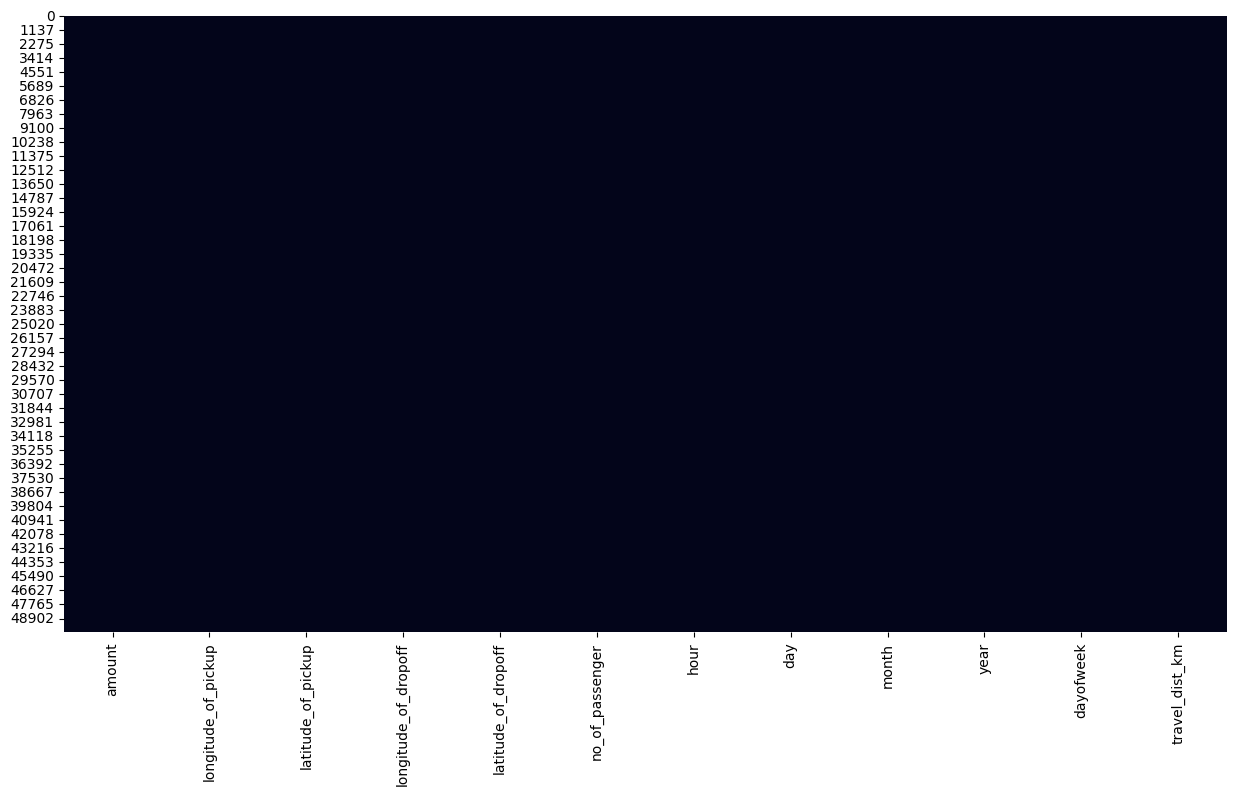

In [ ]:
sns.heatmap(df_taxi.isnull(), cbar=False)
plt.show()

In [ ]:
#Compute a correlation matrix
corr = df_taxi.corr()
corr

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
amount,1.000000,0.005905,-0.006563,0.004452,-0.005600,0.016506,-0.022009,-0.001417,0.026742,0.121081,0.000542,0.016451
longitude_of_pickup,0.005905,1.000000,-0.984132,0.956613,-0.947401,-0.005614,0.004913,0.006008,0.000402,-0.001264,-0.003224,0.143712
latitude_of_pickup,-0.006563,-0.984132,1.000000,-0.943741,0.961374,0.003982,-0.004313,-0.008884,0.000498,-0.000925,0.001911,-0.130943
longitude_of_dropoff,0.004452,0.956613,-0.943741,1.000000,-0.982102,-0.004874,0.005506,0.005221,0.001322,-0.000327,-0.002441,0.143172
latitude_of_dropoff,-0.005600,-0.947401,0.961374,-0.982102,1.000000,0.002898,-0.004530,-0.008012,-0.000341,-0.001817,0.001626,-0.124844
no_of_passenger,0.016506,-0.005614,0.003982,-0.004874,0.002898,1.000000,0.011400,0.006787,0.009099,0.006385,0.038581,-0.005371
hour,-0.022009,0.004913,-0.004313,0.005506,-0.004530,0.011400,1.000000,-0.008192,-0.001916,0.004167,-0.091267,0.000644
day,-0.001417,0.006008,-0.008884,0.005221,-0.008012,0.006787,-0.008192,1.000000,-0.017266,-0.011155,0.008422,0.010610
month,0.026742,0.000402,0.000498,0.001322,-0.000341,0.009099,-0.001916,-0.017266,1.000000,-0.115726,-0.010004,-0.009217
year,0.121081,-0.001264,-0.000925,-0.000327,-0.001817,0.006385,0.004167,-0.011155,-0.115726,1.000000,0.006808,0.022136


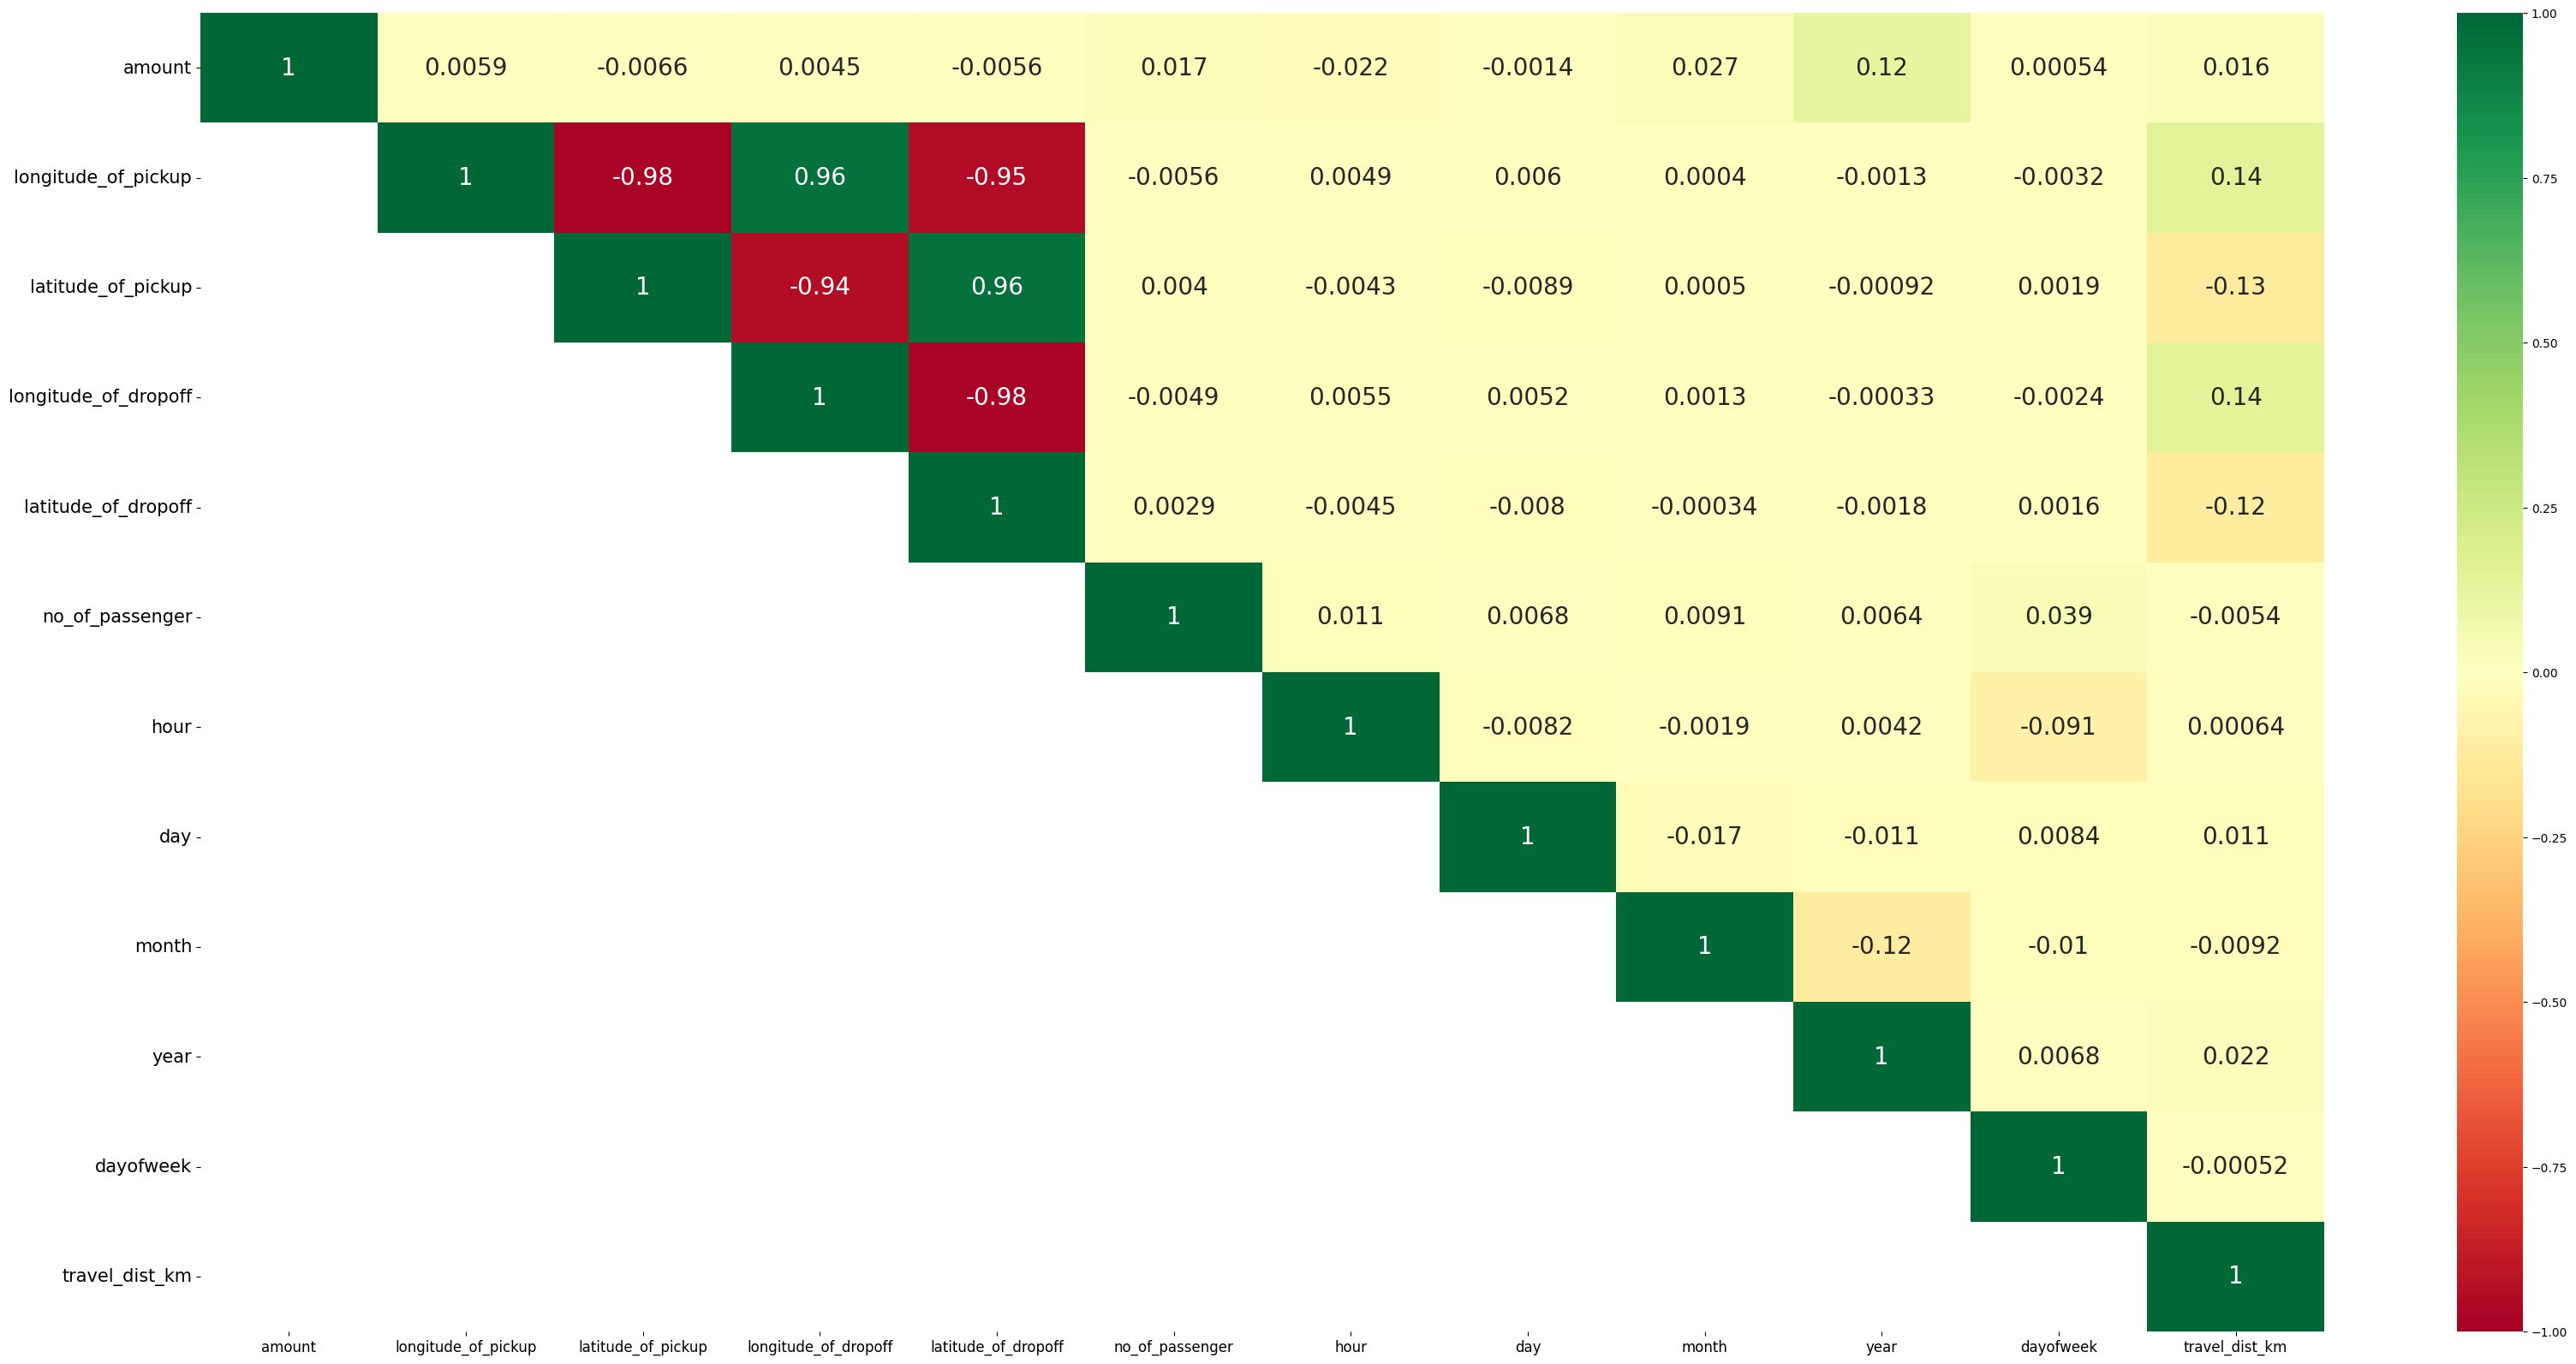

In [ ]:
plt.figure(figsize = (40,20))
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask, k=-1)] = True
sns.heatmap(corr, cmap='RdYlGn', vmax=1.0, vmin=-1.0, annot = True, annot_kws = {"size":20}, mask=mask)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.show()

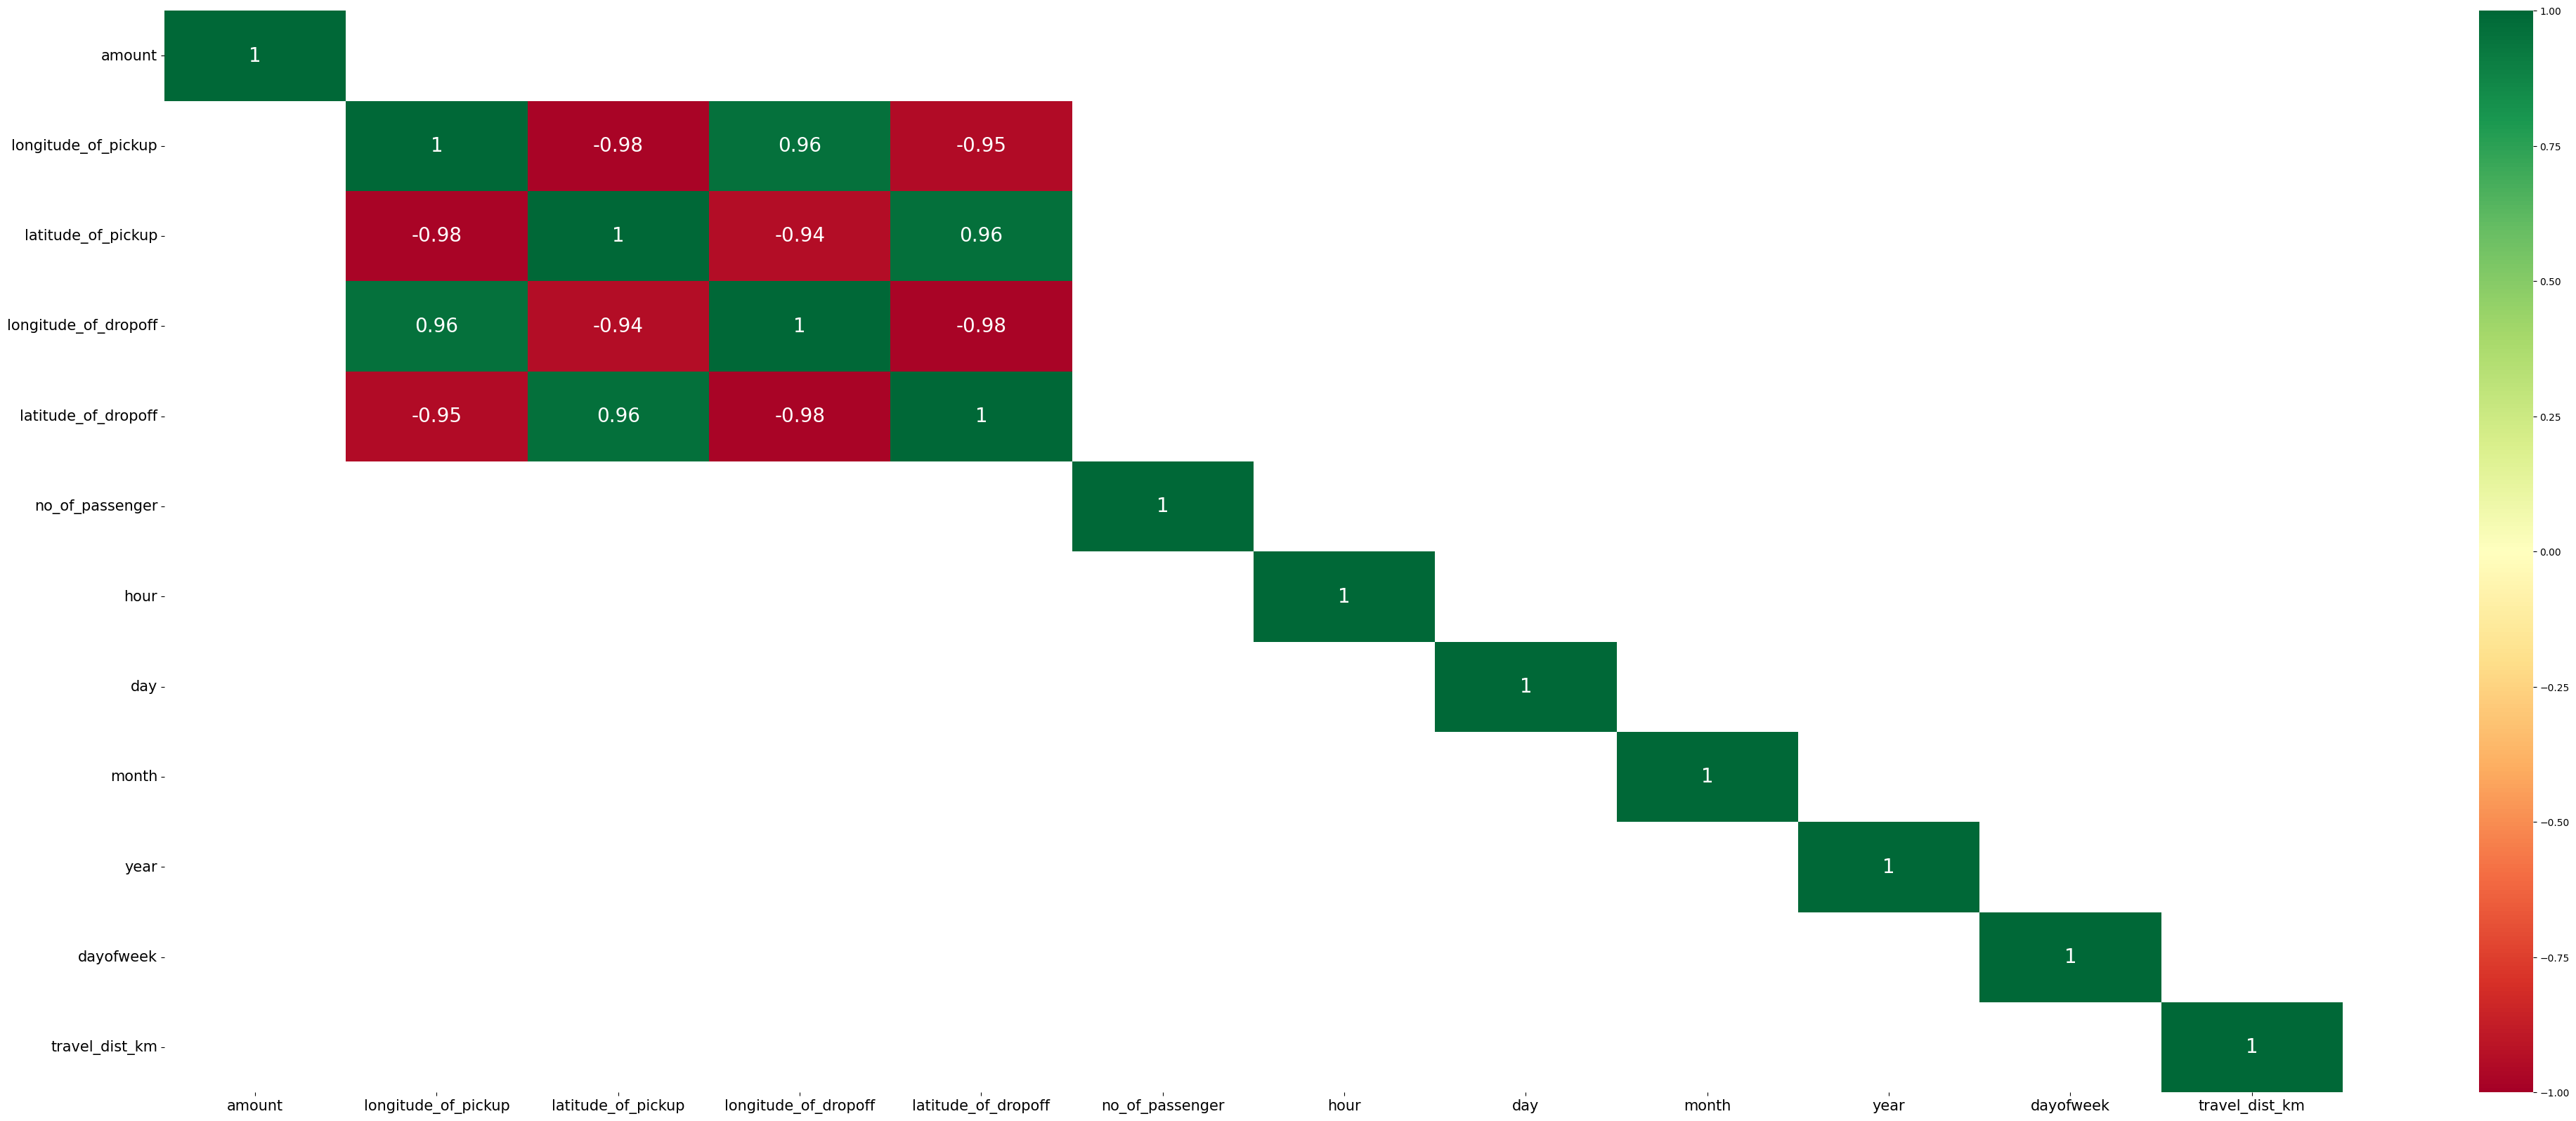

In [ ]:
# set figure size
plt.figure(figsize=(50, 20))

# plot the heat map
# corr: give the correlation matrix
# pass the condition to get the strong correlation between the variables
# cmap: color code used for plotting
# vmax: gives a maximum range of values for the chart
# vmin: gives a minimum range of values for the chart
# annot: prints the correlation values in the chart
# annot_kws: sets the font size of the annotation
#sns.set(font_scale=2)
sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], cmap = 'RdYlGn', vmax = 1.0, vmin = -1.0, annot = True,
            annot_kws={"size": 20})

# set the size of x and y axes labels
# set text size using 'fontsize'
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# display the plot
plt.show()

EDA

<Axes: title={'center': 'Taxi trips count during week days'}, xlabel='hour', ylabel='count'>

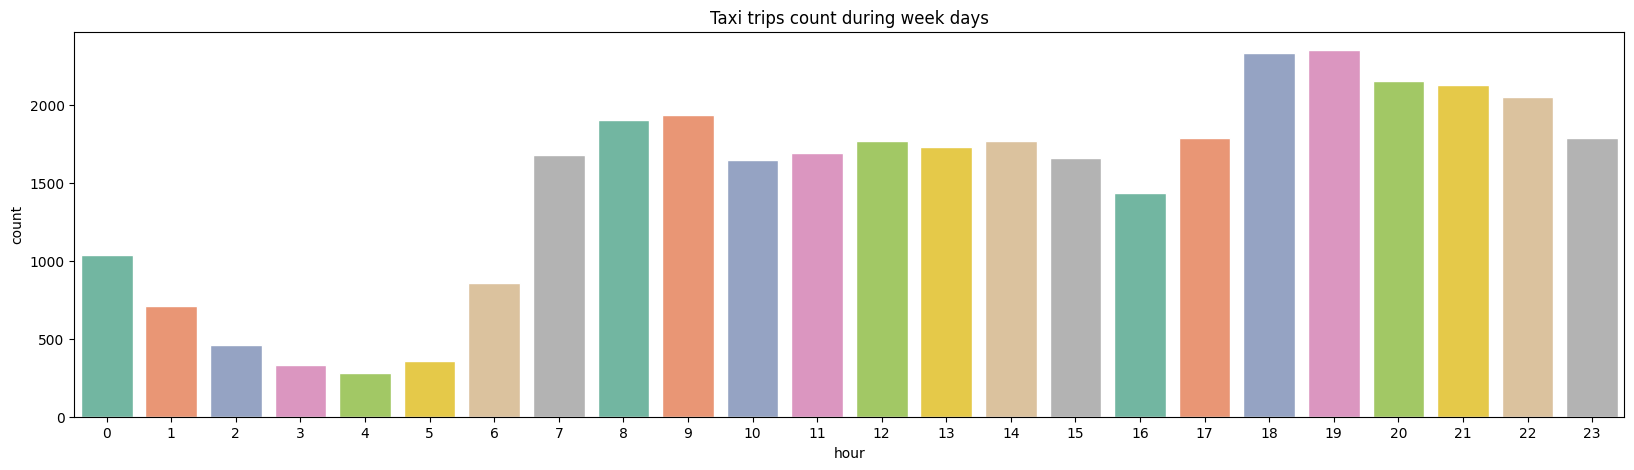

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Taxi trips count during week days")
sns.set_style("white")
sns.countplot(x='hour', data=df_taxi.loc[(df_taxi.dayofweek >= 0) & (df_taxi.dayofweek <= 4)], palette='Set2')

<Axes: title={'center': 'Taxi trips count during week ends'}, xlabel='hour', ylabel='count'>

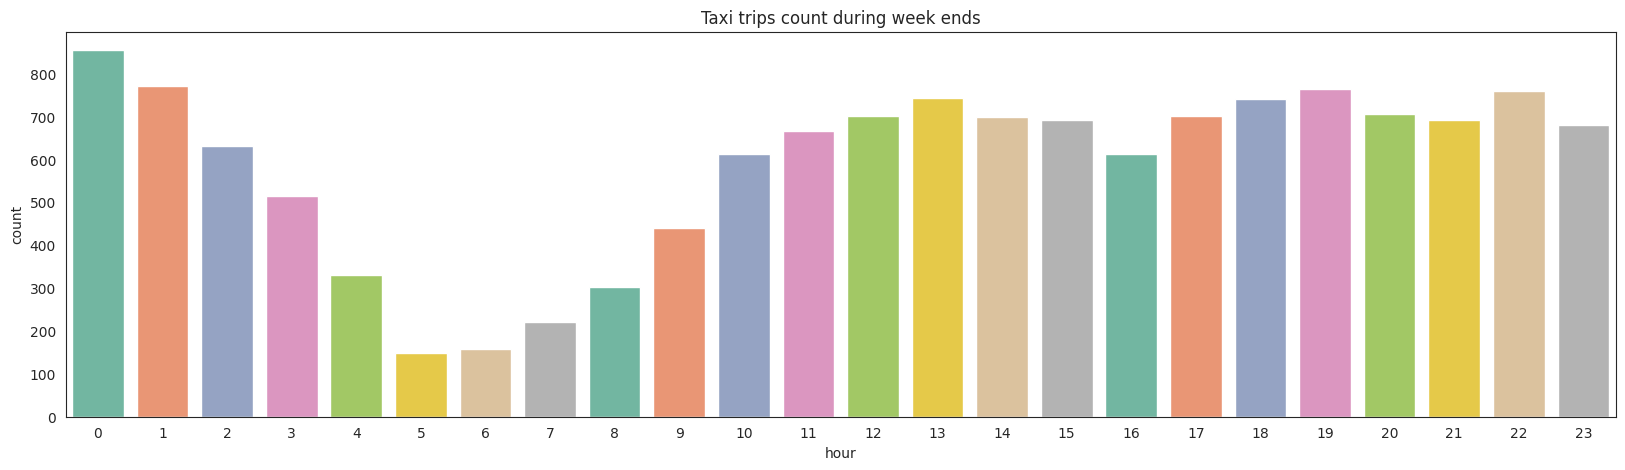

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Taxi trips count during week ends")
sns.set_style("white")
sns.countplot(x='hour', data=df_taxi.loc[(df_taxi.dayofweek >= 5) & (df_taxi.dayofweek <= 6)], palette='Set2')

In [ ]:
week_days = df_taxi.loc[(df_taxi.dayofweek >= 0) & (df_taxi.dayofweek <= 4)]
week_ends = df_taxi.loc[(df_taxi.dayofweek >= 5) & (df_taxi.dayofweek <= 6)]
week_days_fare = week_days.groupby(['hour']).amount.mean().to_frame().reset_index()
week_ends_fare = week_ends.groupby(['hour']).amount.mean().to_frame().reset_index()
week_ends_fare

,hour,amount
0,0,11.733544
1,1,10.991658
2,2,11.476212
3,3,12.249047
4,4,12.704848
5,5,15.059730
6,6,16.821950
7,7,13.081629
8,8,11.554950
9,9,9.805147


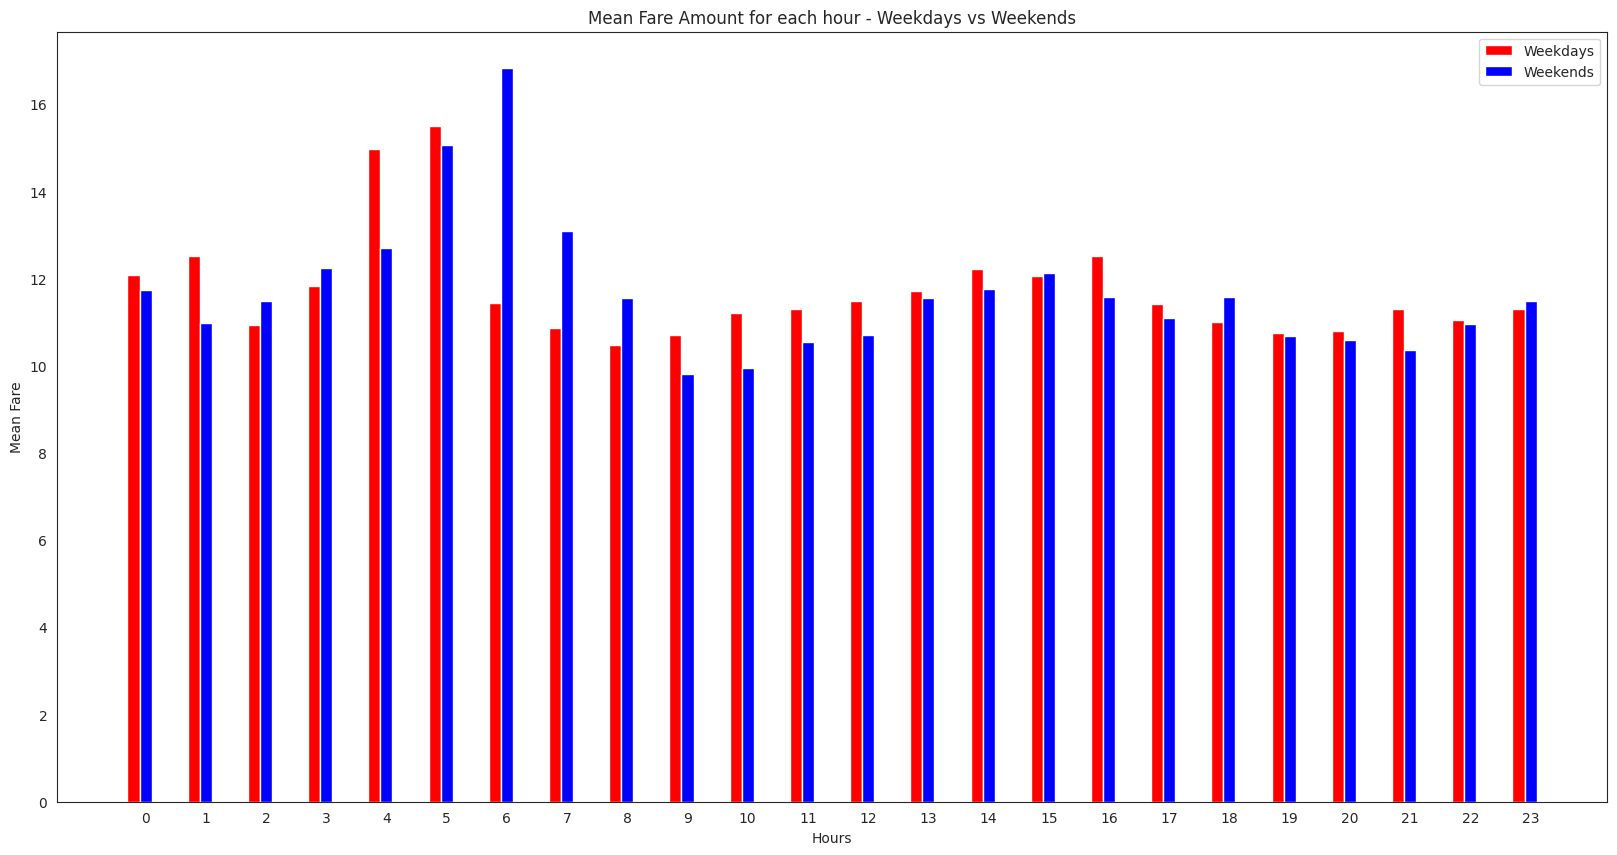

In [ ]:
#plot the mean fare
x=np.array(week_days_fare.hour)
y=np.array(week_days_fare.amount)
z=np.array(week_ends_fare.amount)

plt.figure(figsize=(20,10))
plt.title('Mean Fare Amount for each hour - Weekdays vs Weekends')
plt.xlabel('Hours')
plt.ylabel('Mean Fare')

ax = plt.subplot(1,1,1)
ax.bar(x-0.2, y, width=0.2, color='red', align='center',label='Weekdays')
ax.bar(x,z,width=0.2,color='blue',align='center',label='Weekends')
plt.xticks(range(0,24))
plt.legend()
plt.show()

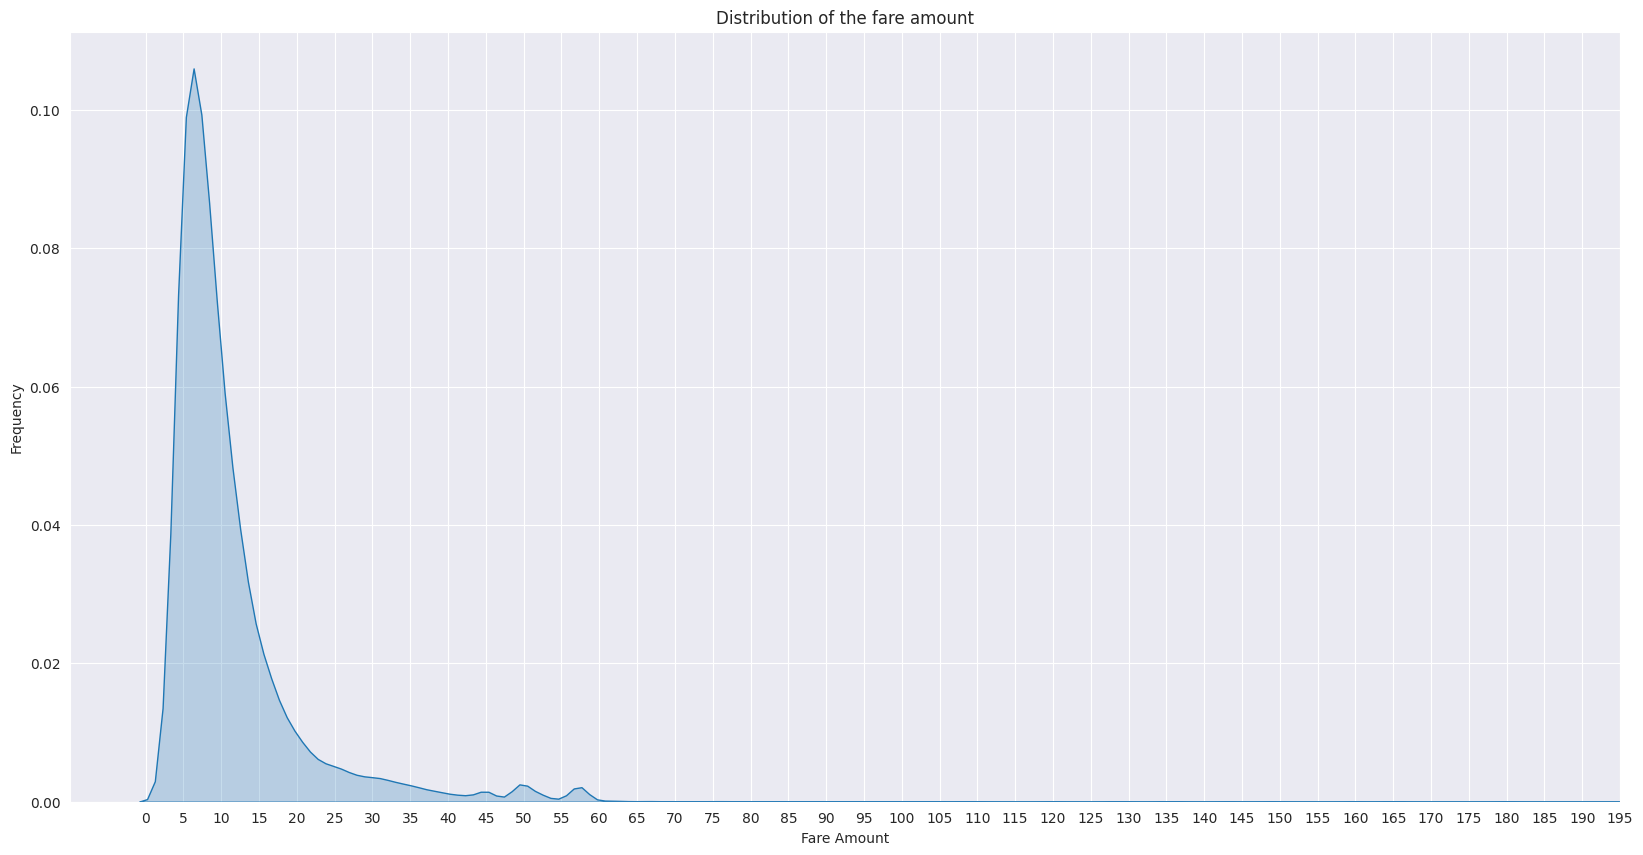

In [ ]:
#Distribution of fare amount
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.title("Distribution of the fare amount")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.xlim(-10,20)
plt.xticks(range(0,200,5))
snsplot = sns.kdeplot(df_taxi.amount, shade=True)

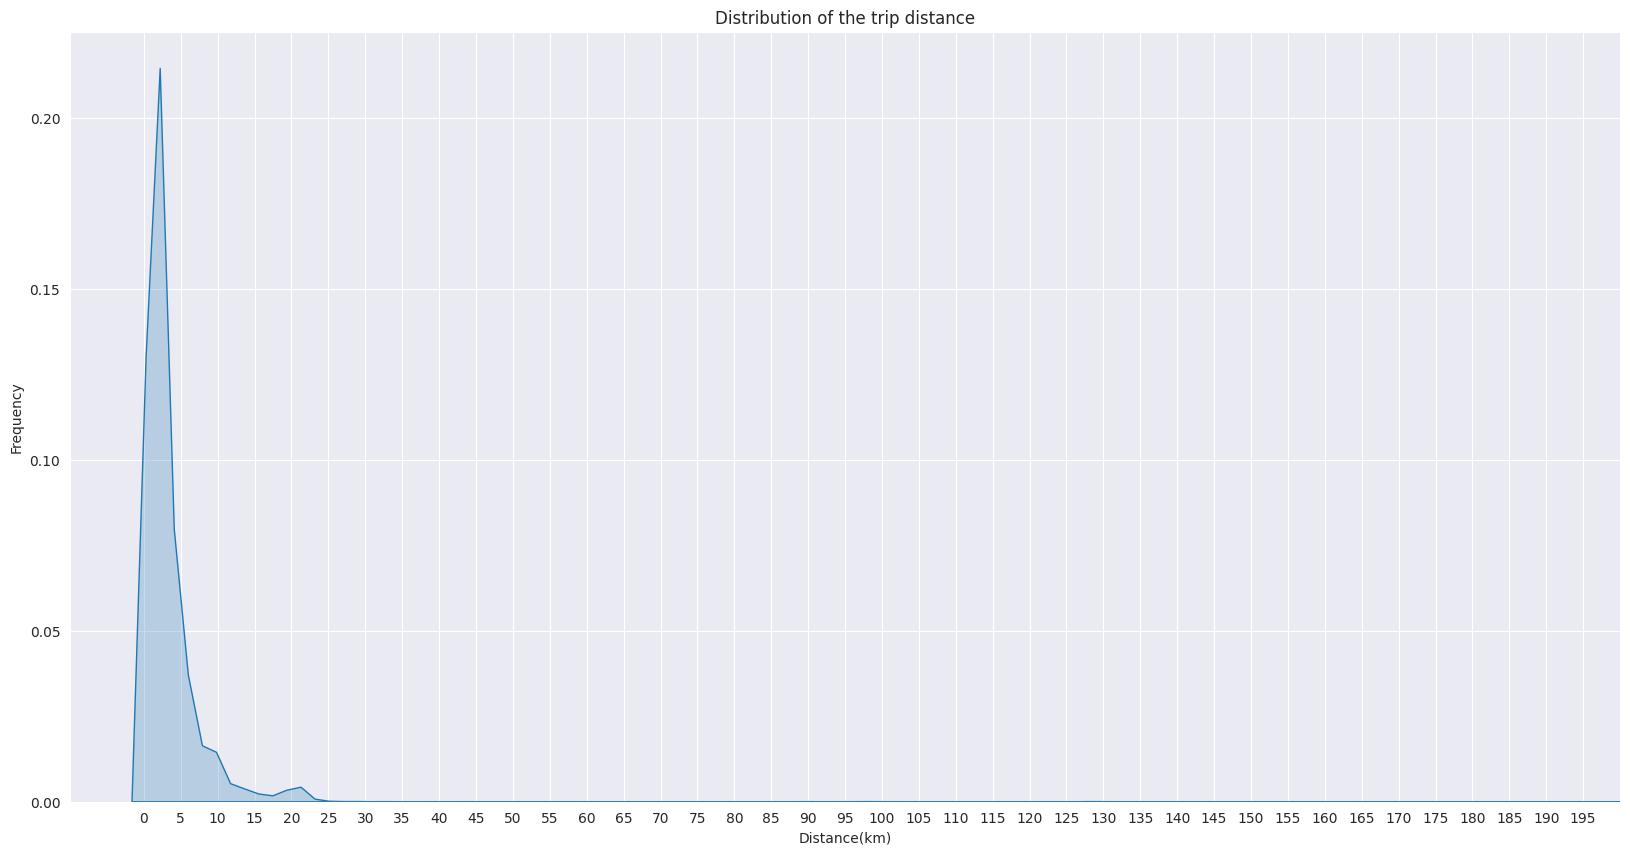

In [ ]:
# Distribution of travel in KM

plt.figure(figsize=(20,10))
sns.style=('darkgrid')
plt.title("Distribution of the trip distance")
plt.xlabel("Distance(km)")
plt.ylabel("Frequency")
plt.xlim(-10,200)
plt.xticks(range(0,200,5))
snsplot = sns.kdeplot(df_taxi[df_taxi.travel_dist_km<600].travel_dist_km, shade=True)

**Random Forest**

In [ ]:
# Split the data into features and target dataframes
y = pd.DataFrame(df_taxi['amount'])
X=df_taxi.drop('amount', axis =1)
X.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


In [ ]:
#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 1)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (34992, 11)
Shape of X_test: (14997, 11)
Shape of y_train: (34992, 1)
Shape of y_test: (14997, 1)


In [ ]:
#Build model using RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators = 100, random_state = 10)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [ ]:
#predict
y_pred = rf_reg.predict(X_test)

In [ ]:
#compute accuracy measures
rf_reg_MAE = metrics.mean_absolute_error(y_test,y_pred)
print("MAE:", rf_reg_MAE)

#MSE
rf_reg_MSE = metrics.mean_squared_error(y_test,y_pred)
print("MSE:", rf_reg_MSE)

#RMSE
rf_reg_RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print("RMSE:", rf_reg_RMSE)

MAE: 2.068533828114829
MSE: 19.630229608323198
RMSE: 4.430601495093324


In [ ]:
#Tabulate the results
cols = ['Model', 'MAE', 'MSE', 'RMSE']
result_tab = pd.DataFrame(columns = cols)
rf_reg_metrics = pd.Series({'Model':'Random Forest',
                            'MAE':rf_reg_MAE,
                            'MSE':rf_reg_MSE,
                            'RMSE':rf_reg_RMSE
                            })
result_tab = pd.concat([result_tab, rf_reg_metrics.to_frame().T], ignore_index = True)
result_tab

,Model,MAE,MSE,RMSE
0,Random Forest,2.068534,19.630230,4.430601


**Random Forest with GridSearchCV**

In [ ]:
tuned_parameters = [{'n_estimators': [85,100],
                     'min_samples_split':[15,20],
                     'max_depth':[8,10]
                     }]

In [ ]:
rf_reg_CV = RandomForestRegressor(random_state = 10)
grid = GridSearchCV(estimator = rf_reg_CV,
                    param_grid = tuned_parameters,
                    cv = 10)
dt_grid = grid.fit(X_train, y_train)
print('Best parameters for random forest regressor: ', dt_grid.best_params_,'\n')

Best parameters for random forest regressor:  {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 85} 



In [ ]:
dt_grid_model = RandomForestRegressor(n_estimators = dt_grid.best_params_.get('n_estimators'),
                                      max_depth = dt_grid.best_params_.get('max_depth'),
                                      min_samples_split = dt_grid.best_params_.get('min_samples_split'),
                                      random_state = 10)
dt_grid_model = dt_grid_model.fit(X_train,y_train)

In [ ]:
y_pred = dt_grid_model.predict(X_test)

In [ ]:
#compute accuracy measures
rf_reg_CV_MAE = metrics.mean_absolute_error(y_test,y_pred)
print("MAE:", rf_reg_CV_MAE)

#MSE
rf_reg_CV_MSE = metrics.mean_squared_error(y_test,y_pred)
print("MSE:", rf_reg_CV_MSE)

#RMSE
rf_reg_CV_RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print("RMSE:", rf_reg_CV_RMSE)

In [ ]:
rf_reg_metrics = pd.Series({'Model':'Random Forest with Grid Search',
                            'MAE':rf_reg_CV_MAE,
                            'MSE':rf_reg_CV_MSE,
                            'RMSE':rf_reg_CV_RMSE
                            })
result_tab = pd.concat([result_tab, rf_reg_metrics.to_frame().T], ignore_index = True)
result_tab